# 1. Objetivo

La idea del proycto es realizar una clasificación de imágenes en tres clases -> Frutas, Vegetales y Paquetes.

#### data set reference
```
  title={A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels},
  author={Klasson, Marcus and Zhang, Cheng and Kjellstr{\"o}m, Hedvig},
  booktitle={IEEE Winter Conference on Applications of Computer Vision (WACV)},
  year={2019}
```

## Un puntapie de inicio

In [44]:
!pip install -q keras

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K
from keras import layers
from keras import models

#### Vamos a crear algunas funciones útiles

In [43]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Descarga y Armado del dataset

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6553, done.
remote: Total 6553 (delta 0), reused 0 (delta 0), pack-reused 6553
Receiving objects: 100% (6553/6553), 116.24 MiB | 44.78 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [ ]:
## fijamos los paths
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

In [ ]:
!ls GroceryStoreDataset/dataset/train/Fruit

Apple	 Kiwi	Mango	   Orange	  Peach      Plum	     Satsumas
Avocado  Lemon	Melon	   Papaya	  Pear	     Pomegranate
Banana	 Lime	Nectarine  Passion-Fruit  Pineapple  Red-Grapefruit


## 2.2 Preprocesamiento inicial de los datos
Creamos algunos preprocesamientos sin ningun variación ni aumento de los datos. Este es el comienzo :)

In [45]:
train_batches  = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [46]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


# 3. Crear un Modelo base Convolusional

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 96)                37850208  
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 291       
Total params: 37,851,395
Trainable params: 37,851,395
Non-trainable params: 0
_________________________________________________________________


In [48]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=5,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/5
83/82 [==============================] - 9s 107ms/step - loss: 2.3626 - acc: 0.5545 - val_loss: 1.5151 - val_acc: 0.5270
Epoch 2/5
83/82 [==============================] - 9s 104ms/step - loss: 1.1447 - acc: 0.6614 - val_loss: 1.1599 - val_acc: 0.5946
Epoch 3/5
83/82 [==============================] - 9s 105ms/step - loss: 0.7764 - acc: 0.7064 - val_loss: 1.3629 - val_acc: 0.5439
Epoch 4/5
83/82 [==============================] - 9s 104ms/step - loss: 0.5921 - acc: 0.7489 - val_loss: 1.3539 - val_acc: 0.4966
Epoch 5/5
83/82 [==============================] - 9s 104ms/step - loss: 0.4667 - acc: 0.8034 - val_loss: 0.9425 - val_acc: 0.6284


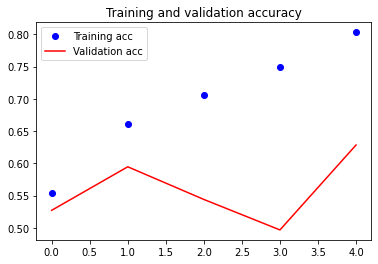

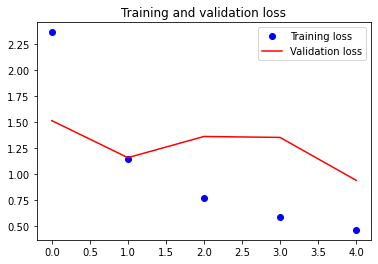

In [49]:

import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.1.1 Experimentar con el modelo... Prueben hacer un modelo un poco más complejo, con:
 
 Capa convolusional con 32 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 64 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa de Aplanamiento
 
 Capa Densa con 512 neuronas
 
 Capa de clasificación con la categorías.
 
 ** y obviamente probar con más épocas ** 
 
 Se recomienda entrenar con gpu (o en colab), aunque puede andar sin, aunque bastante lento

In [80]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 52, 52, 128)     

In [94]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=20,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/20
83/82 [==============================] - 15s 177ms/step - loss: 0.0419 - acc: 0.9879 - val_loss: 0.3486 - val_acc: 0.8986
Epoch 2/20
83/82 [==============================] - 14s 165ms/step - loss: 0.0397 - acc: 0.9894 - val_loss: 0.4238 - val_acc: 0.9020
Epoch 3/20
83/82 [==============================] - 14s 171ms/step - loss: 0.0147 - acc: 0.9958 - val_loss: 0.4960 - val_acc: 0.8682
Epoch 4/20
83/82 [==============================] - 14s 167ms/step - loss: 0.0204 - acc: 0.9913 - val_loss: 0.4755 - val_acc: 0.8986
Epoch 5/20
83/82 [==============================] - 14s 163ms/step - loss: 0.0418 - acc: 0.9905 - val_loss: 0.4815 - val_acc: 0.8953
Epoch 6/20
83/82 [==============================] - 13s 162ms/step - loss: 0.0406 - acc: 0.9917 - val_loss: 0.4695 - val_acc: 0.8953
Epoch 7/20
83/82 [==============================] - 13s 162ms/step - loss: 0.0047 - acc: 0.9981 - val_loss: 0.9263 - val_acc: 0.8277
Epoch 8/20
83/82 [==============================] - 14s 163ms/step - 

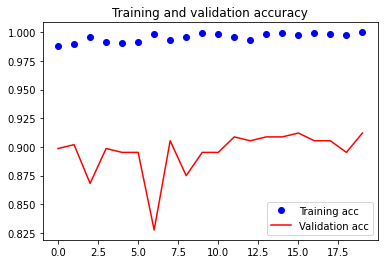

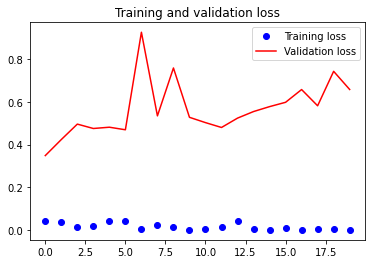

In [95]:
acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 3.2 Hacer Aumento de datos

Para el mismo modelo que armamos arriba (es decir, una vez que definan uno, se quedan con ese), hagamos un poco de aumento de cantidad de datos. Es una buena forma de tener más datos y prevenir también el overfitting. 

Se puede aumentar los datos con los generadores de entrenamiento. Se recomienta usar reescalamiento, recorte, zoom y espejado horizontal.

* reescalar los inputs de 0,255 a 0,1
* aplicar el rango de recorte (shear_range) para aplicar cortes aleatorios
* aplicar rango de zoom (zoom_range) para aplicar zoom aleatorio a las imágenes
* poner true el espejado horizontal (horizontal_flip) para obtener imágenes espejo horizontales)

Recuerden usar las mismas funciones de activación y optimización, para poder probar el mismo modelo.

Siempre recuerden plotear validación contra training para ver si hay overfitting.

Recuerden que hay que reescalar el test también, porque el modelo aprendió a utilizar los datos escalados

un buen lugar para consultar sobre Image Data Generator (la herramienta para aumentar los datos)
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [ ]:
#### Les dejo algo de código para que vayan empezando

train_datagen = ImageDataGenerator(
        rotation_range=###,
        width_shift_range=###,
        height_shift_range=0.###,
        fill_mode=#####,
        rescale=####,
        shear_range=####,
        zoom_range=####,
        horizontal_flip=####)

test_datagen = ImageDataGenerator(rescale=####)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_2 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)




SyntaxError: invalid syntax (<ipython-input-43-0962f03a2602>, line 5)

### 3.3 Más aumentos de imágenes 

Probemos agregar otros aumentos:

* rango de rotación (rotation_range) rota las imagenes.
* desplazar las imagenes aleatoriamente con (width_shift) en ancho
* desplazar las imagenes aleatoriamente con (height_shift) en ancho
* poner fill_mode en nearest para completar la imagen.


### 3.3 Regularización: Añadir capa o capas de dropout para regularizar.


Se hizo en el punto 3.1.1

# 4. Utilizar una Red Preentrenada y hacer Fine-Tuning!

Probar con VGG16, recortando las últimas capas de la red para hacer fine tuning. El que se anime, puede probar ResNet también que es una red con una arquitectura bastante más compleja!

Recuerden que tienen que setear cuáles serán las capas a entrenar.
Les dejo documentación al respecto! :)

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [83]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [84]:
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 100
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [85]:
model = Sequential()

vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:]:
    layer.trainable = False

model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_21 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_46 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 25,694,211
Non-trainable params: 14,714,688
_________________________________________________________________


In [86]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=
         validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/20
27/26 [==============================] - 16s 600ms/step - loss: 1.0442 - acc: 0.7375 - val_loss: 0.3275 - val_acc: 0.8649
Epoch 2/20
27/26 [==============================] - 14s 511ms/step - loss: 0.3579 - acc: 0.8500 - val_loss: 0.2850 - val_acc: 0.8649
Epoch 3/20
27/26 [==============================] - 14s 514ms/step - loss: 0.3105 - acc: 0.8898 - val_loss: 0.4349 - val_acc: 0.7973
Epoch 4/20
27/26 [==============================] - 13s 491ms/step - loss: 0.2250 - acc: 0.9068 - val_loss: 0.3396 - val_acc: 0.8750
Epoch 5/20
27/26 [==============================] - 13s 486ms/step - loss: 0.1723 - acc: 0.9292 - val_loss: 0.2681 - val_acc: 0.8750
Epoch 6/20
27/26 [==============================] - 13s 484ms/step - loss: 0.1469 - acc: 0.9500 - val_loss: 0.3132 - val_acc: 0.8784
Epoch 7/20
27/26 [==============================] - 13s 491ms/step - loss: 0.1255 - acc: 0.9644 - val_loss: 0.2879 - val_acc: 0.8919
Epoch 8/20
27/26 [==============================] - 13s 497ms/step - 

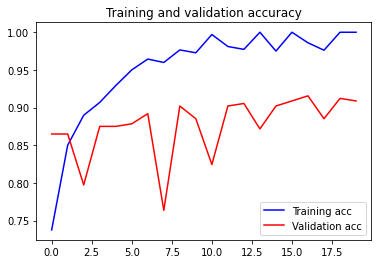

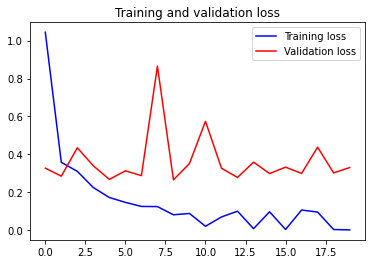

In [87]:
# function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Run the function to illustrate accuracy and loss
visualize_results(history)

[[0.0, 1.0, 0.0]]
Package


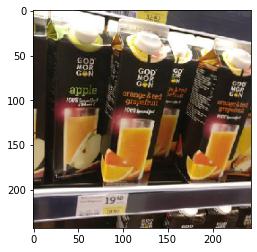

In [88]:
path = './GroceryStoreDataset/dataset/val/Packages/Juice/God-Morgon-Orange-Red-Grapefruit-Juice/God-Morgon-Orange-Red-Grapefruit-Juice_004.jpg'
img=image.load_img(path, target_size=(243, 243))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
prediction = model.predict(images, batch_size=10)

prediction = prediction.tolist()
print(prediction)

if prediction==[[1.0, 0.0, 0.0]]:
    print('Fruit')
elif prediction==[[0.0, 1.0, 0.0]]:
    print('Package')
else:
  print ('Vegetable')

plt.imshow(img)


In [92]:
# function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    fnames = validation_generator.filenames
    ground_truth = validation_generator.classes
    label2index = validation_generator.class_indices
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)
    predicted_classes = np.argmax(predictions, axis=1)
    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    return idx2label, errors, fnames


# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = image.load_img('{}/{}'.format(validation_path,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

30/29 [==============================] - 2s 57ms/step
The list of classes:  ['Fruit', 'Packages', 'Vegetables']
Number of errors = 27/296


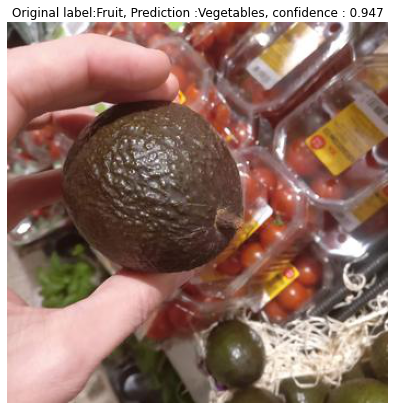

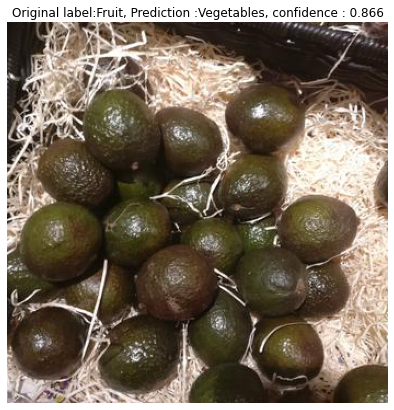

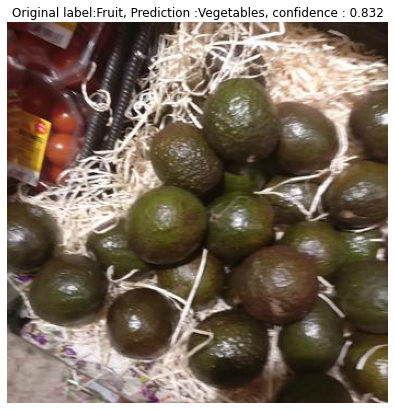

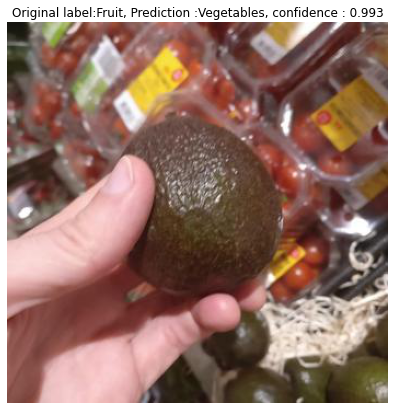

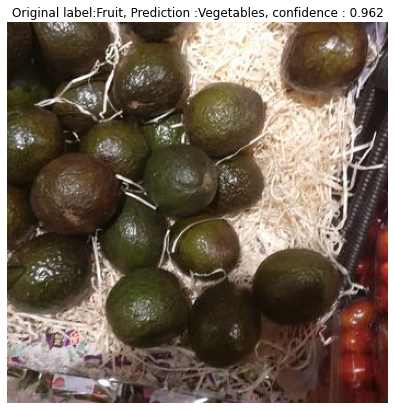

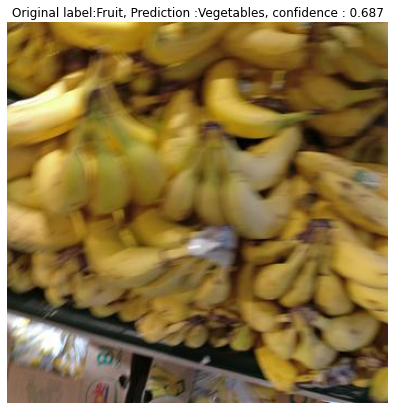

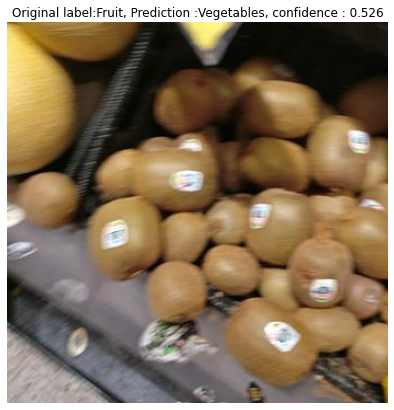

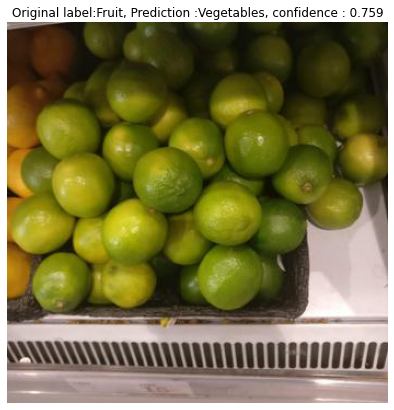

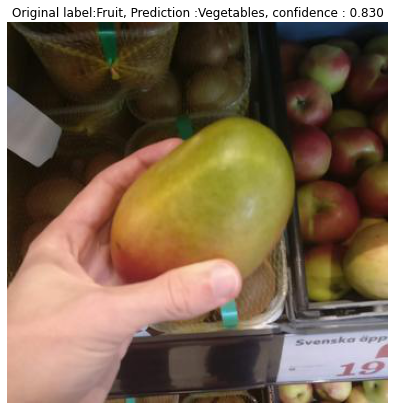

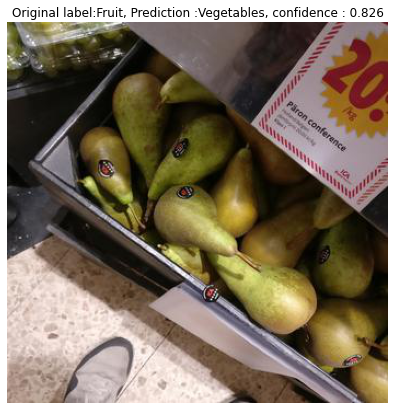

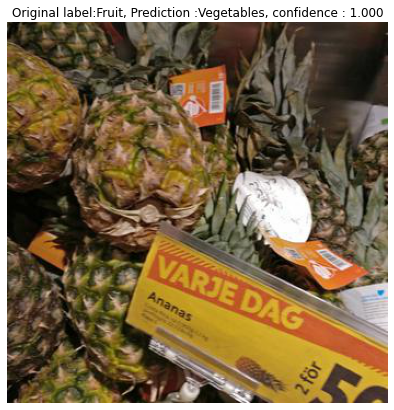

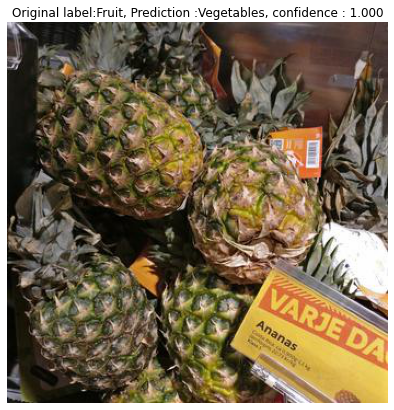

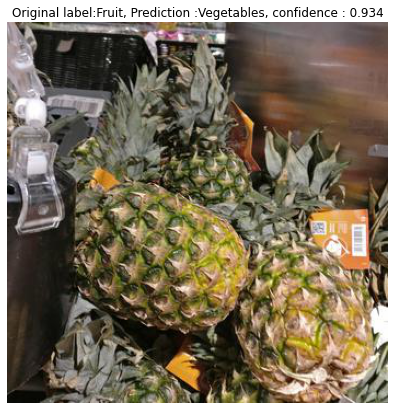

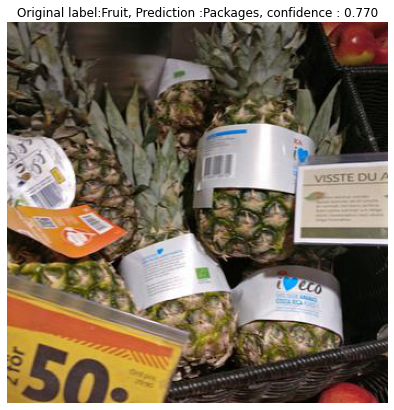

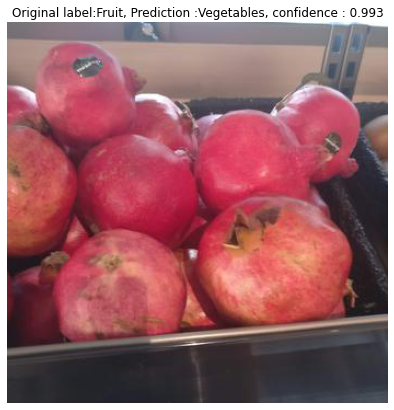

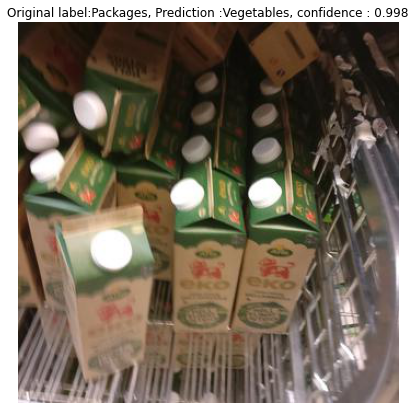

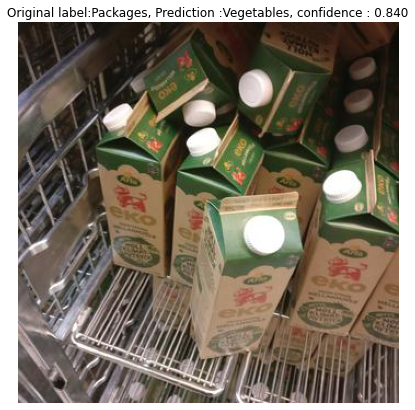

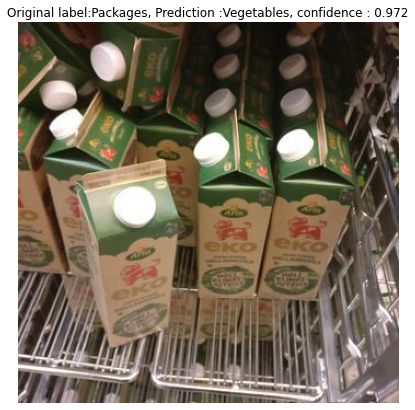

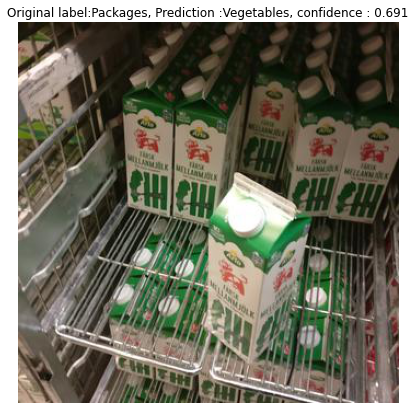

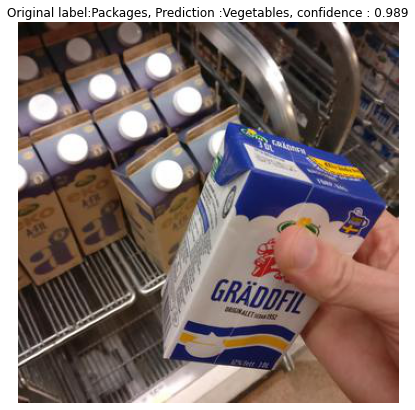

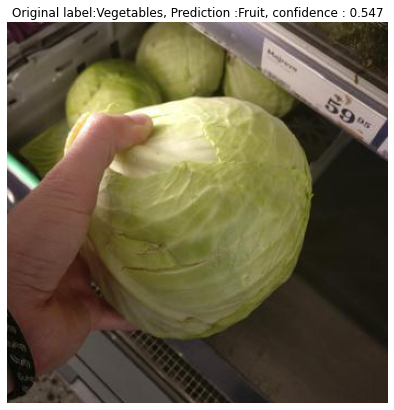

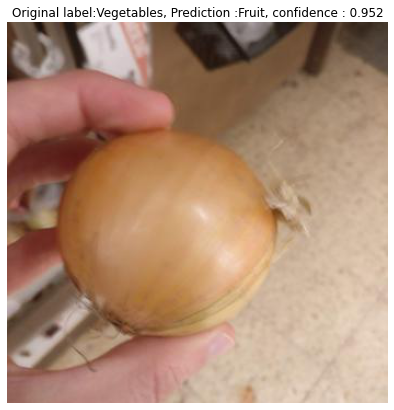

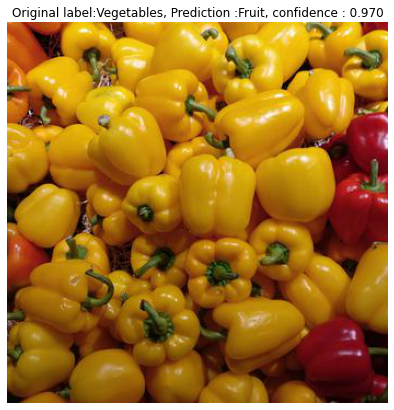

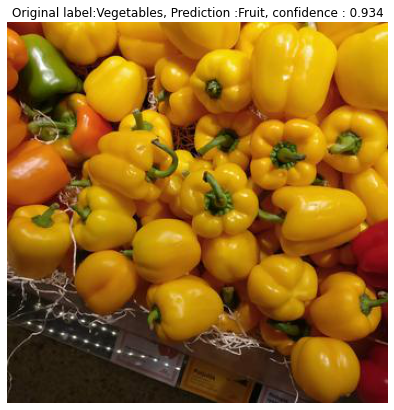

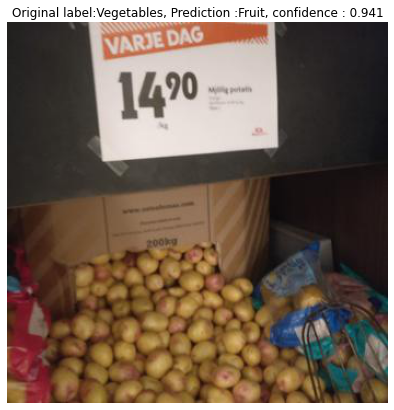

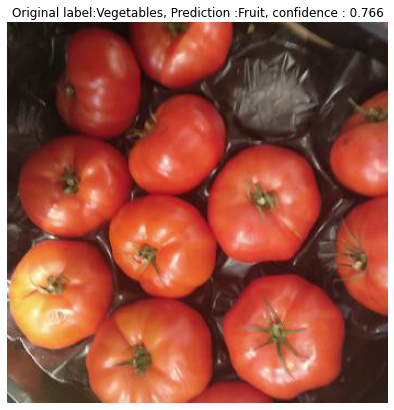

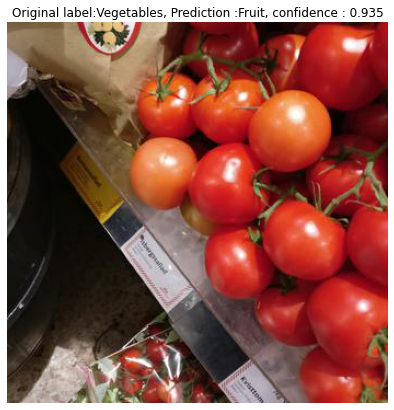

In [93]:
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

idx2label, errors, fnames = obtain_errors(validation_generator, predictions)

show_errors(idx2label, errors, predictions, fnames)